# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1QBiVk40P9nuUbW0QS5xB5Q3BeArEva6p/view?usp=sharing 

In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab4_Data_Imputation.ipynb"

[NbConvertApp] Converting notebook /content/Lab4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 690754 bytes to /content/Lab4_Data_Imputation.html


In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [ ]:
import torch.nn.functional as F
targets_df = pd.DataFrame(data=subdf)
my_tensor = torch.tensor(targets_df.values)
normal_tensor = F.normalize(my_tensor.double())
normal_tensor

tensor([[1.7933e-02, 5.9777e-03, 9.9965e-01, 0.0000e+00, 1.8393e-02],
        [9.3856e-01, 2.4403e-01, 0.0000e+00, 0.0000e+00, 2.4403e-01],
        [6.7976e-01, 1.6100e-01, 0.0000e+00, 0.0000e+00, 7.1554e-01],
        ...,
        [8.1658e-01, 1.2671e-01, 0.0000e+00, 0.0000e+00, 5.6316e-01],
        [7.0821e-01, 2.8972e-01, 0.0000e+00, 0.0000e+00, 6.4382e-01],
        [3.4611e-03, 5.9904e-04, 9.9999e-01, 0.0000e+00, 2.6624e-03]],
       dtype=torch.float64)

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Male")

21790

In [ ]:
sum(df["sex"] == " Male")/df.shape[0]

0.6692054912318418

### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]
df

,age,yredu,capgain,caploss,workhr,work,marriage,occupation,edu,relationship,sex
0,39,13,2174,0,40,State-gov,Never-married,Adm-clerical,Bachelors,Not-in-family,Male
1,50,13,0,0,13,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Bachelors,Husband,Male
2,38,9,0,0,40,Private,Divorced,Handlers-cleaners,HS-grad,Not-in-family,Male
3,53,7,0,0,40,Private,Married-civ-spouse,Handlers-cleaners,11th,Husband,Male
4,28,13,0,0,40,Private,Married-civ-spouse,Prof-specialty,Bachelors,Wife,Female
...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,0,38,Private,Married-civ-spouse,Tech-support,Assoc-acdm,Wife,Female
32557,40,9,0,0,40,Private,Married-civ-spouse,Machine-op-inspct,HS-grad,Husband,Male
32558,58,9,0,0,40,Private,Widowed,Adm-clerical,HS-grad,Unmarried,Female
32559,22,9,0,0,20,Private,Never-married,Adm-clerical,HS-grad,Own-child,Male


In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]
df_with_missing

,age,yredu,capgain,caploss,workhr,work,marriage,occupation,edu,relationship,sex
27,54,10,0,0,60,?,Married-civ-spouse,?,Some-college,Husband,Male
61,32,4,0,0,40,?,Married-spouse-absent,?,7th-8th,Not-in-family,Male
69,25,10,0,0,40,?,Never-married,?,Some-college,Own-child,Male
77,67,6,0,0,2,?,Married-civ-spouse,?,10th,Husband,Male
106,17,6,34095,0,32,?,Never-married,?,10th,Own-child,Female
...,...,...,...,...,...,...,...,...,...,...,...
32530,35,13,0,0,55,?,Married-civ-spouse,?,Bachelors,Wife,Female
32531,30,13,0,0,99,?,Never-married,?,Bachelors,Not-in-family,Female
32539,71,16,0,0,10,?,Married-civ-spouse,?,Doctorate,Husband,Male
32541,41,9,0,0,32,?,Separated,?,HS-grad,Not-in-family,Female


In [ ]:
df_not_missing

,age,yredu,capgain,caploss,workhr,work,marriage,occupation,edu,relationship,sex
0,39,13,2174,0,40,State-gov,Never-married,Adm-clerical,Bachelors,Not-in-family,Male
1,50,13,0,0,13,Self-emp-not-inc,Married-civ-spouse,Exec-managerial,Bachelors,Husband,Male
2,38,9,0,0,40,Private,Divorced,Handlers-cleaners,HS-grad,Not-in-family,Male
3,53,7,0,0,40,Private,Married-civ-spouse,Handlers-cleaners,11th,Husband,Male
4,28,13,0,0,40,Private,Married-civ-spouse,Prof-specialty,Bachelors,Wife,Female
...,...,...,...,...,...,...,...,...,...,...,...
32556,27,12,0,0,38,Private,Married-civ-spouse,Tech-support,Assoc-acdm,Wife,Female
32557,40,9,0,0,40,Private,Married-civ-spouse,Machine-op-inspct,HS-grad,Husband,Male
32558,58,9,0,0,40,Private,Widowed,Adm-clerical,HS-grad,Unmarried,Female
32559,22,9,0,0,20,Private,Never-married,Adm-clerical,HS-grad,Own-child,Male


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
set(df_not_missing["work"])

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,39,13,2174,0,40,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,50,13,0,0,13,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,38,9,0,0,40,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
data.shape[1] # come from the touple data.shape which gives row and column numbers

57

In [ ]:
# normalize df
tar_col = ["age", "yredu", "capgain", "caploss", "workhr"]
min_col = data[tar_col].min()
max_col = data[tar_col].max()
for col in tar_col:
    diff = max_col[col]-min_col[col]
    if diff != 0:
        data[col] = (data[col]-min_col[col])/diff
    else:
        data[col] = 1
data

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.021740,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.733333,0.000000,0.0,0.377551,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
32557,0.315068,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
32558,0.561644,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
32559,0.068493,0.533333,0.000000,0.0,0.193878,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    target_index = np.argmax(onehot)
    values = cat_values[feature]
    cat = values[target_index]
    return cat

cat_index
cat_values
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

'Private'

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
data

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.021740,0.0,0.397959,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.733333,0.000000,0.0,0.377551,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
32557,0.315068,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
32558,0.561644,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
32559,0.068493,0.533333,0.000000,0.0,0.193878,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1


In [ ]:

# import math
# # set the numpy seed for reproducibility
# # https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
# np.random.seed(50)
# my_tensor = torch.tensor(data.values)
# normal_tensor = F.normalize(my_tensor.double())
# len = normal_tensor.shape[0]
# train_data = normal_tensor[:math.floor(len*0.7)]
# val_data = normal_tensor[math.floor(len*0.7):math.floor(len*0.85)]
# test_data = normal_tensor[math.floor(len*0.85):]
# train_data.shape

# # commented out because I want the data to be in the format of dataset instead of tensor

In [ ]:
rng = np.random.default_rng(50)
num_row, num_col = datanp.shape
train_num, val_num = int(num_row*0.7), int(num_row*0.15)
test_num = num_row - train_num - val_num

train_set = rng.choice(datanp, size= train_num)
val_set = rng.choice(datanp, size= val_num)
test_set = rng.choice(datanp, size= test_num)
print("training： {}\nvalidation: {}\ntest : {}".format(train_num, val_num, test_num))

training： 21502
validation: 4607
test : 4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.name = "autoencoder"
        self.encoder = nn.Sequential(
            nn.Linear(57, 11), # TODO -- FILL OUT THE CODE HERE!
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The goal of AutoEncoder is to reconstruct the output in the same format of the input. Since we turned the into into values between 0 and 1 with normalization and one-hot encording, we want to use the Sigmoid function to map the real value input to be bounded by 0 and 1. This will also make the training process converge faster.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
import matplotlib.pyplot as plt
import os

def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "./saved_model/model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                                 batch_size,
                                                                 learning_rate,
                                                                 epoch)
    return path

def train(model, train_loader, valid_loader, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    # check if there exists a separate model folder exist for saving pretrained weight
    if not os.path.exists('./saved_model'):
        os.mkdir('./saved_model')
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, loss_record= [], []
    val_iter, val_loss, val_acc = [], [], []
    n = 0

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # For trainig loss
            iters.append(n)
            loss_record.append(float(loss)/batch_size)
            n += 1
        # Save model to path
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        # Validate the model
        val_l = 0
        for val_data in valid_loader:
            datam = zero_out_random_feature(val_data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, val_data)
            optimizer.zero_grad()
            val_l += float(loss)/batch_size
        val_iter.append(n)
        val_loss.append(val_l/len(valid_loader))
        print("loss: ",val_l/len(valid_loader))
   # For plotting
    plt.title("Loss Training Curve")
    plt.plot(iters, loss_record, label="Train")
    plt.plot(val_iter, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

In [ ]:
catcols

['work', 'marriage', 'occupation', 'edu', 'relationship', 'sex']

In [ ]:
cat_index

{'work': 5,
 'marriage': 12,
 'occupation': 19,
 'edu': 33,
 'relationship': 49,
 'sex': 55}

In [ ]:
cat_values

{'work': ['Federal-gov',
  'Local-gov',
  'Private',
  'Self-emp-inc',
  'Self-emp-not-inc',
  'State-gov',
  'Without-pay'],
 'marriage': ['Divorced',
  'Married-AF-spouse',
  'Married-civ-spouse',
  'Married-spouse-absent',
  'Never-married',
  'Separated',
  'Widowed'],
 'occupation': ['Adm-clerical',
  'Armed-Forces',
  'Craft-repair',
  'Exec-managerial',
  'Farming-fishing',
  'Handlers-cleaners',
  'Machine-op-inspct',
  'Other-service',
  'Priv-house-serv',
  'Prof-specialty',
  'Protective-serv',
  'Sales',
  'Tech-support',
  'Transport-moving'],
 'edu': ['10th',
  '11th',
  '12th',
  '1st-4th',
  '5th-6th',
  '7th-8th',
  '9th',
  'Assoc-acdm',
  'Assoc-voc',
  'Bachelors',
  'Doctorate',
  'HS-grad',
  'Masters',
  'Preschool',
  'Prof-school',
  'Some-college'],
 'relationship': ['Husband',
  'Not-in-family',
  'Other-relative',
  'Own-child',
  'Unmarried',
  'Wife'],
 'sex': ['Female', 'Male']}

In [ ]:
train_set.shape, val_set.shape

((21502, 57), (4607, 57))

loss:  0.000987541733290224
loss:  0.0007747515960040295
loss:  0.0006316257761985374
loss:  0.0005242260287761585
loss:  0.00044974277706286457
loss:  0.000399054598043828
loss:  0.00036027873890513246
loss:  0.0003461750677363145
loss:  0.0003232723429391626
loss:  0.0003231027367291972
loss:  0.00031536759646163165
loss:  0.0002983147494685707
loss:  0.000286378653173516
loss:  0.00030135040873978543
loss:  0.0002778733511756097
loss:  0.00027409503753814433
loss:  0.000280633541074672
loss:  0.0002748540785736016
loss:  0.0002707252978224359
loss:  0.0002773771116658787
loss:  0.00026378484593199875
loss:  0.0002655806466565183
loss:  0.0002671676245679717
loss:  0.0002500467320108631
loss:  0.0002583570674485398
loss:  0.00025614251414178096
loss:  0.0002599098964613707
loss:  0.0002486648089769814
loss:  0.0002483756436251699
loss:  0.00023903265314907508


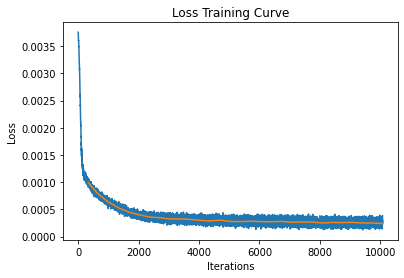

In [ ]:
def train_fcn(net, train_set, val_set, batch_size = 64, num_epoch = 30, learning_rate = 1e-3):
    train_l = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
    val_l = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=True)
    train(net, train_l, val_l,batch_size=batch_size, num_epochs=num_epoch,learning_rate=learning_rate)
b_s = 64
num_e = 30
lr = 1e-3
#########################################################

autoencoder = AutoEncoder()
train_fcn(autoencoder, train_set, val_set)

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

In [ ]:
def train_w_acc(model, train_loader, valid_loader, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    # check if there exists a separate model folder exist for saving pretrained weight
    if not os.path.exists('./saved_model'):
        os.mkdir('./saved_model')
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    iters, loss_record, epoch_num, acc_record = [], [], [], []
    val_iter, val_loss, val_acc = [], [], []
    n = 0

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # For trainig loss
            iters.append(n)
            loss_record.append(float(loss)/batch_size)
            n += 1
        # Training accuracy
        epoch_num.append(epoch)
        acc_record.append(get_accuracy(model, train_loader))
        # Save model to path
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
        # Validate the model
        val_l = 0
        for val_data in valid_loader:
            datam = zero_out_random_feature(val_data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, val_data)
            optimizer.zero_grad()
            val_l += float(loss)/batch_size
        val_iter.append(n)
        val_loss.append(val_l/len(valid_loader))
        print("loss: ",val_l/len(valid_loader))
        val_acc.append(get_accuracy(model, valid_loader))
        print("accuracy: ",get_accuracy(model, valid_loader))
   # For plotting
    plt.title("Loss Training Curve")
    plt.plot(iters, loss_record, label="Train")
    plt.plot(val_iter, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Training Curve")
    plt.plot(epoch_num, acc_record, label="Train")
    plt.plot(epoch_num, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final training accuracy: {}".format(acc_record[-1]))
    print("Final validation accuracy: {}".format(val_acc[-1]))

In [ ]:
def train_acc_fcn(net, train_set, val_set, batch_size = 64, num_epoch = 30, learning_rate = 1e-3):
    train_l = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
    val_l = torch.utils.data.DataLoader(val_set,batch_size=batch_size, shuffle=True)
    train_w_acc(net, train_l, val_l,batch_size=batch_size, num_epochs=num_epoch,learning_rate=learning_rate)

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

loss:  0.0009933501819937697
accuracy:  0.48129657767165906
loss:  0.0007978537404495808
accuracy:  0.5381665581361696
loss:  0.0006275574560277164
accuracy:  0.5705086462629332
loss:  0.0005159205005232556
accuracy:  0.5996671731423197
loss:  0.0004462299645335103
accuracy:  0.6130164242818898
loss:  0.0003976221936075793
accuracy:  0.6218797482092469
loss:  0.0003684226099317635
accuracy:  0.6252441936184068
loss:  0.0003408832607318699
accuracy:  0.624737717965415
loss:  0.00032635150354407314
accuracy:  0.6223138701975255
loss:  0.00032470423583516903
accuracy:  0.6244483033065624
loss:  0.0003096897451339626
accuracy:  0.6253165472831199
loss:  0.00030223209493366693
accuracy:  0.6252803704507633
loss:  0.0003000185162010085
accuracy:  0.6239780044859272
loss:  0.00029017904186427285
accuracy:  0.6286086390275667
loss:  0.00028227524550554034
accuracy:  0.6276318645539397
loss:  0.00027060145354577497
accuracy:  0.6320454381014399
loss:  0.0002769945286773792
accuracy:  0.63027277

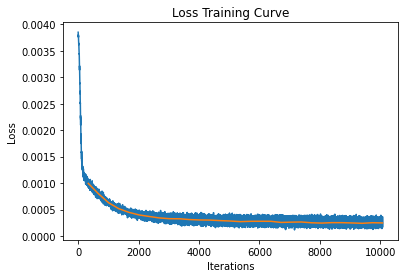

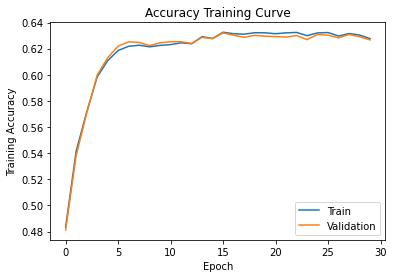

Final training accuracy: 0.6276625430192541
Final validation accuracy: 0.6266912669126691


In [ ]:
autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

1st try: From the graphs in part c, we can see that the default hyperparameters have better training accuracy that validation accuracy. This could be a signal of overfitting. To improve this, I plan on using smaller batch size, for the following reason:

Small batches can oﬀer a regularizing eﬀect (Wilson and Martinez, 2003), perhaps due to the noise they add to the learning process. Generalization error is often best for a batch size of 1. Training with such a small batch size might require a small learning rate to maintain stability because of the high variance in the estimate of the gradient.

loss:  0.0015853442431155902
accuracy:  0.5557846754938137
loss:  0.0010663561826934004
accuracy:  0.604478691845742
loss:  0.0008315911242486133
accuracy:  0.6211200347297591
loss:  0.000730970746695271
accuracy:  0.6166702843499023
loss:  0.0006634408992896271
accuracy:  0.6155849793792055
loss:  0.0006278790561838024
accuracy:  0.6164170465234065
loss:  0.0005921232617159452
accuracy:  0.6173214673323204
loss:  0.0005726703982670895
accuracy:  0.6197814919325664
loss:  0.0005624282708191054
accuracy:  0.6215903335503943
loss:  0.0005452747437731079
accuracy:  0.6235077056652919
loss:  0.0005297524728828446
accuracy:  0.6196729614354967
loss:  0.0005431328880957961
accuracy:  0.6231097605093698
loss:  0.0005321729398322835
accuracy:  0.6251718399536936
loss:  0.0005383044721788287
accuracy:  0.6203241444179147
loss:  0.0005317912966549759
accuracy:  0.6217350408798206
loss:  0.0005317702743923292
accuracy:  0.6230735836770133
loss:  0.0004967243421560852
accuracy:  0.6222415165328123

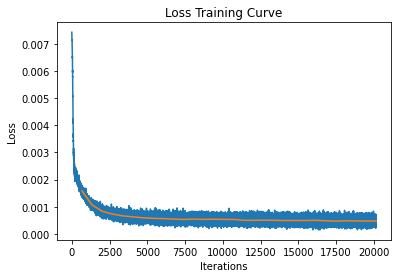

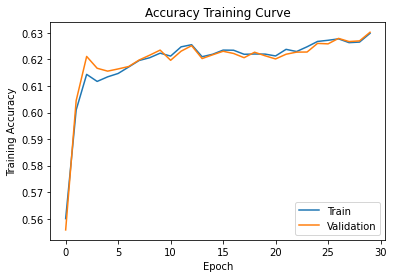

Final training accuracy: 0.6298251325458097
Final validation accuracy: 0.6302365964836119


In [ ]:
# 2nd try: 
autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set, batch_size = 32, num_epoch = 30, learning_rate = 1e-3)

The 2nd try's result is very good since both accuracy values have increased and the validation accuracy is even higher than training accuracy. To further improve both accuracy values, I plan on trying more number of epochs, since no sign of overfitting tells us that we have room to keep on fitting to the data.

loss:  0.0015793648522554173
accuracy:  0.5559655596555966
loss:  0.0010497039074834902
accuracy:  0.6074813689313364
loss:  0.0008347856944763205
accuracy:  0.6175747051588163
loss:  0.0007433816372213187
accuracy:  0.618008827147095
loss:  0.0006696830017366059
accuracy:  0.621698864047464
loss:  0.0006299650898048034
accuracy:  0.6175747051588163
loss:  0.0006120902805074971
accuracy:  0.6213009188915418
loss:  0.0006022374202277408
accuracy:  0.6252441936184068
loss:  0.0005583678369778985
accuracy:  0.6291151146805586
loss:  0.0005604982496960373
accuracy:  0.6288618768540627
loss:  0.0005498882575112577
accuracy:  0.6316113161131611
loss:  0.0005443509423154561
accuracy:  0.6316836697778743
loss:  0.0005170674298319176
accuracy:  0.6325157369220751
loss:  0.0005227351702059321
accuracy:  0.6331669199044931
loss:  0.0005268762931033658
accuracy:  0.6307430721366037
loss:  0.0005119610850670142
accuracy:  0.6320454381014399
loss:  0.0004981467242638852
accuracy:  0.6326966210838579

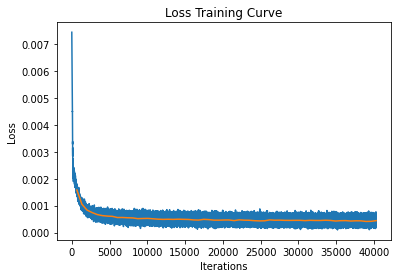

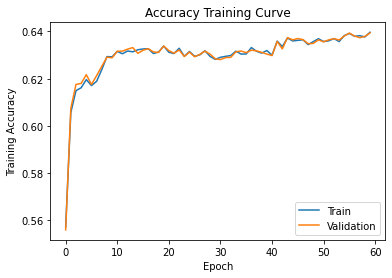

Final training accuracy: 0.6396769292778967
Final validation accuracy: 0.6393893350698213


In [ ]:
# 3rd try: 
autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set, batch_size = 32, num_epoch = 60, learning_rate = 1e-3)

The accuracy has increased after the 3rd try. In the fourth try, I will lower the learning rate, which as mentioned in the 1st try, will also maintain stability when finding the gradient.

loss:  0.001993604977744528
accuracy:  0.49851674987338107
loss:  0.0016240265516292614
accuracy:  0.5483684248607192
loss:  0.0013189867208388427
accuracy:  0.582085232617032
loss:  0.001086771342670545
accuracy:  0.607264307937197
loss:  0.0009290337442911954
accuracy:  0.6152593878879965
loss:  0.0008191682512309247
accuracy:  0.6195282541060705
loss:  0.0007610533563517189
accuracy:  0.619238839447218
loss:  0.0007121096194977225
accuracy:  0.6212285652268288
loss:  0.0006678504000269135
accuracy:  0.6232182910064394
loss:  0.0006566925247979169
accuracy:  0.6231821141740829
loss:  0.0006193742137838854
accuracy:  0.6211562115621156
loss:  0.000586584051941625
accuracy:  0.6227841690181608
loss:  0.000593072158355628
accuracy:  0.6219159250416033
loss:  0.0005703703197165547
accuracy:  0.6230735836770133
loss:  0.000549640467700859
accuracy:  0.6239056508212141
loss:  0.0005515661937857254
accuracy:  0.6249186021271977
loss:  0.0005462199814145505
accuracy:  0.6242312423124231
loss

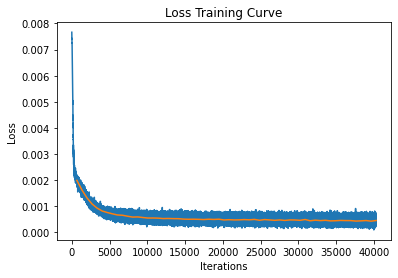

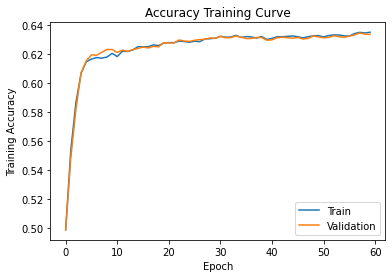

Final training accuracy: 0.6351192137165534
Final validation accuracy: 0.6336372187251285


In [ ]:
# 4th try: 
autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set, batch_size = 32, num_epoch = 60, learning_rate = 5e-4)

The 4th try shows a little overfitting and less accuracy than the 3rd try. Thus. the 3rd try is our best choice for hyperparameters.

loss:  0.0016438609438612023
accuracy:  0.5384197959626655
loss:  0.001127477597037796
accuracy:  0.6070110701107011
loss:  0.0008469937775872597
accuracy:  0.6188770711236524
loss:  0.0007203428338268875
accuracy:  0.6149337963967875
loss:  0.0006538732561441268
accuracy:  0.6125823022936112
loss:  0.0006091142414435227
accuracy:  0.6126546559583242
loss:  0.0005814262965739343
accuracy:  0.6141017292525867
loss:  0.0005808426667499589
accuracy:  0.6145720280732219
loss:  0.0005546644800536645
accuracy:  0.6132696621083857
loss:  0.0005466929629215479
accuracy:  0.6144273207437957
loss:  0.0005244070756210325
accuracy:  0.6148614427320743
loss:  0.0005111172371875404
accuracy:  0.6141379060849432
loss:  0.0005155647917894789
accuracy:  0.6131973084436727
loss:  0.0005082500061285424
accuracy:  0.6158382172057014
loss:  0.0005005886586230998
accuracy:  0.6151508573909269
loss:  0.0005126863290772437
accuracy:  0.6164170465234065
loss:  0.0005078632100574194
accuracy:  0.614897619564430

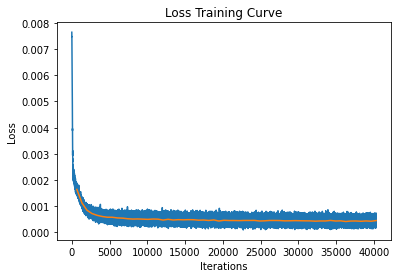

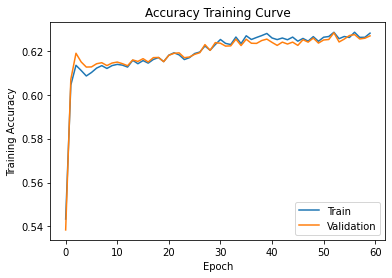

Final training accuracy: 0.6280268502154839
Final validation accuracy: 0.6267997974097388


In [ ]:
# 3rd try (run again to get saved models)
autoencoder = AutoEncoder()
train_acc_fcn(autoencoder, train_set, val_set, batch_size = 32, num_epoch = 60, learning_rate = 1e-3)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_loader = torch.utils.data.DataLoader(test_set,batch_size=32, shuffle=True)

net = AutoEncoder()
# Obtain the last model
net.load_state_dict(torch.load('./saved_model/model_autoencoder_bs32_lr0.001_epoch29'))
print(get_accuracy(net, test_loader))

0.6264916467780429


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
catcols

['work', 'marriage', 'occupation', 'edu', 'relationship', 'sex']

In [ ]:
def get_baseline_accuracy(data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    cat_dict = {} # counter for occurances of each feature in each catogory
    for col in catcols:
        col_dict = {} # counter for occurances of each feature in each column
        for item in data_loader: # minibatches
            for ele in range(item.shape[0]):
                feat = get_feature(item[ele], col)
                if feat in col_dict:
                    col_dict[feat] += 1
                else:
                    col_dict[feat] = 1
        cat_dict[col] = col_dict
        max_k = max(col_dict, key = col_dict.get) # For each column find the max occurance value
        cat_dict[col] = max_k # leave only the most frequency value
        print(cat_dict)
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            # print(inp)
            for i in range(inp.shape[0]): # record in minibatch
                acc += int(cat_dict[col] == get_feature(inp[i], col))
                total += 1
    return acc / total
get_baseline_accuracy(test_loader)

{'work': 'Private'}
{'work': 'Private', 'marriage': 'Married-civ-spouse'}
{'work': 'Private', 'marriage': 'Married-civ-spouse', 'occupation': 'Craft-repair'}
{'work': 'Private', 'marriage': 'Married-civ-spouse', 'occupation': 'Craft-repair', 'edu': 'HS-grad'}
{'work': 'Private', 'marriage': 'Married-civ-spouse', 'occupation': 'Craft-repair', 'edu': 'HS-grad', 'relationship': 'Husband'}
{'work': 'Private', 'marriage': 'Married-civ-spouse', 'occupation': 'Craft-repair', 'edu': 'HS-grad', 'relationship': 'Husband', 'sex': 'Male'}


0.467093368048022

### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy from part a was 62.65% whereas the baseline accuracy is 46.71%.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

Yes, it would be reasonble for a human to predict a person's education based on their occupation and class level.

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
test_loader = torch.utils.data.DataLoader(test_set,batch_size=32, shuffle=False)

person = next(iter(test_loader)) # get a person
print(person)
inp = person.detach().numpy()
data = zero_out_feature(person.clone(), "edu")
out = net(data).detach().numpy()
get_feature(out[0], "edu")

tensor([[0.3288, 0.6000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.3973, 0.8667, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.5342, 0.6000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.1233, 0.5333, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.3014, 0.8667, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.0822, 0.5333, 0.0000,  ..., 0.0000, 1.0000, 0.0000]])


'HS-grad'

### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
col_dict = {}
for item in test_loader: # minibatches
    for ele in range(item.shape[0]):
        feat = get_feature(item[ele], "edu")
        if feat in col_dict:
            col_dict[feat] += 1
        else:
            col_dict[feat] = 1
max_k = max(col_dict, key = col_dict.get)

print("baseline's prediction for education level: ", max_k)

baseline's prediction for education level:  HS-grad
